## Geisterr usage statistics
This notebook analyzes Geisterr usage statistics from log files. The geisterr software writes into a log file into the folder where it is installed. As the installation folder is on a fileserver drive, multiple computers write into the same log file. Whenever started, the program writes this in the log file:
```
Mo 26. Okt 16:41:23 2015
No of CPU cores: 4
Size of Memory: 8430084096
Geisterr SVN-Revision: git e01341b6 
Geisterr SVN-Date: May 18th 2015
Geisterr Version: 2144
Hostname: <obfuscated>
```
When the program is finished, it writes this:
```
StartDateTime: Mo 26. Okt 16:41:23 2015
EndDateTime: Di 27. Okt 19:53:33 2015
RunningTime: 97929
autoResizeFactor: 2.143589
recent FPS: 15.26
Hostname: <obfuscated>
```
By analyzing the log files, we can plot usage statistics over time. Therefore, we search for the date in the first block. The provided `usage_combined.txt` file consists of manually concatenated log files from multiple fileserver shares. The hostname written into the log file was obfuscated.

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import matplotlib

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)
    
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [2]:
with open('usage_combined.txt') as f:
    lines = f.readlines()
    
text = "Hostname: \n\n\n\n" + ("\n".join(lines))

This is how some blocks from the log file look like:

In [3]:
all_data = text.split("Hostname: ")
all_data[1].split("\n\n")

['',
 '',
 'Wed 23. Apr 07:58:48 2014',
 'No of CPU cores: 16',
 'Size of Memory: 12867309568',
 'Geisterr SVN-Revision: 1286',
 'Geisterr SVN-Date: April 23rd 2014',
 'Geisterr Version: 2144',
 '']

In [4]:
all_data[5].split("\n\n")

['<obfuscated>',
 '',
 'StartDateTime: Do 22. Mai 16:35:26 2014',
 'EndDateTime: Do 22. Mai 16:46:22 2014',
 'RunningTime: 656',
 'autoResizeFactor: 1.210000',
 'recent FPS: 17.00',
 '']

In [5]:
def parse_for_date(block):
    # Go through one block
    for line in block.split("\n"):
        if len(line) > 0:
            # Ignore lines such as:
            # 'StartDateTime: Do 22. Mai 16:35:26 2014'
            # 'EndDateTime: Do 22. Mai 16:46:22 2014'
            # 'RunningTime: 656'
            if line[:8] != "Geisterr" and "Time:" not in line:            
                last_five = line[-5:]
                maybe_year = last_five.strip()
                if len(maybe_year) == 4 and maybe_year.isnumeric():
                    #print(maybe_year)
                    year = float(maybe_year)
                    if year >= 2014 and year < 2023:
                        # Translate German and Polish dates to English dates
                        date_time_str = line.replace("Mai","May").\
                                             replace("Okt","Oct").\
                                             replace("Mrz","Mar").\
                                             replace("Dez","Dec").\
                                             replace("Do", "Thu").\
                                             replace("Fr", "Fri").\
                                             replace("Mi", "Wed").\
                                             replace("Mo", "Mon").\
                                             replace("Monn", "Mon").\
                                             replace("ma", "Mon").\
                                             replace("wo", "Wed").\
                                             replace("vr", "Fri").\
                                             replace("di", "Tue").\
                                             replace("do", "Tue").\
                                             replace("okt", "Oct").\
                                             replace("Di", "Tue").\
                                             replace("Sa", "Sat").\
                                             replace("So", "Sun")
                        #print(date_time_str)
                        date = datetime.strptime(date_time_str, '%a %d. %b %H:%M:%S %Y')
                        #print(date.day, date.month, date.year)
                        return date
    return None

days_used = {}
usages = []
for data in all_data:
    date = parse_for_date(data)
    if date is not None:
        days_used[date.strftime("%Y-%m-%d")] = True
        usages.append(date)


In [6]:
df2 = pd.DataFrame({"date":usages})
df2

,date
0,2014-04-23 07:58:48
1,2014-05-13 10:46:12
2,2014-05-22 08:51:58
3,2014-05-22 16:35:26
4,2014-06-05 18:04:58
...,...
3659,2019-01-04 11:49:00
3660,2019-01-11 14:58:18
3661,2019-01-16 10:11:18
3662,2019-01-16 10:28:07


Summarize usage dates in weeks or months

In [7]:
df2["year"] = [d.year for d in df2["date"]]
df2["week"] = [d.week for d in df2["date"]]
df2["month"] = [d.month for d in df2["date"]]


df2

,date,year,week,month
0,2014-04-23 07:58:48,2014,17,4
1,2014-05-13 10:46:12,2014,20,5
2,2014-05-22 08:51:58,2014,21,5
3,2014-05-22 16:35:26,2014,21,5
4,2014-06-05 18:04:58,2014,23,6
...,...,...,...,...
3659,2019-01-04 11:49:00,2019,1,1
3660,2019-01-11 14:58:18,2019,2,1
3661,2019-01-16 10:11:18,2019,3,1
3662,2019-01-16 10:28:07,2019,3,1


In [8]:
summarized2 = df2.groupby(['year', 'month']).size().reset_index(name='counts')

summarized2['month_num'] = [y + m / 12 for y, m in zip(summarized2['year'], summarized2['month'])] 

summarized2

,year,month,counts,month_num
0,2014,4,42,2014.333333
1,2014,5,232,2014.416667
2,2014,6,261,2014.500000
3,2014,7,252,2014.583333
4,2014,8,131,2014.666667
5,2014,9,116,2014.750000
6,2014,10,208,2014.833333
7,2014,11,185,2014.916667
8,2014,12,79,2015.000000
9,2015,1,71,2015.083333


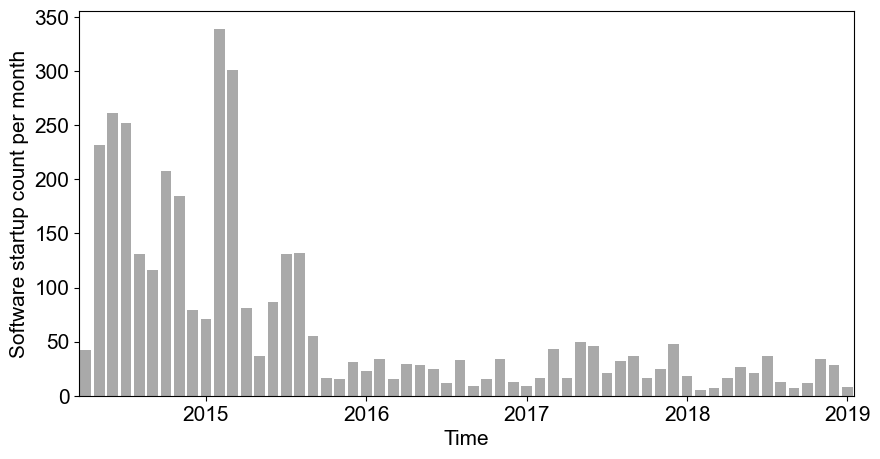

In [9]:
before = 2014
ticklabels = []
ticks = []
for i, year in enumerate(summarized2['year']):
    if year != before:
        ticklabels.append(year)
        ticks.append(i)
    else:
        ticklabels.append(None)
    before = year
        
fig, ax = plt.subplots(figsize=(10,5))

seaborn.barplot(summarized2, ax=ax, x="month_num", y="counts", color='darkgrey') #, hue='year')

ax.set(xticklabels=ticklabels)
ax.set(xticks=ticks)
ax.set_ylabel('Software startup count per month')
ax.set_xlabel('Time')
None